In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import quantum_imaging as qi
from IPython.display import Image
import numpy as np
%matplotlib inline

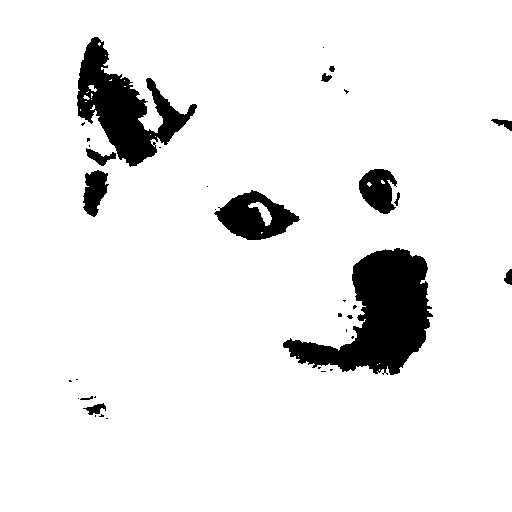

In [2]:
image_doge = qi.convert_to_bw("doge.png") # WoW ! *Much* quantum! *very* doge!
qi.image_from_array(image_doge)

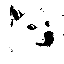

In [3]:
resized_image_doge = qi.resize_array(image_doge, size=(64, 64))
qi.image_from_array(resized_image_doge)

In [4]:
array_binary_doge = qi.binary_encode(resized_image_doge)
qi.save_bin_array_to_csv('doge.csv', array_binary_doge)

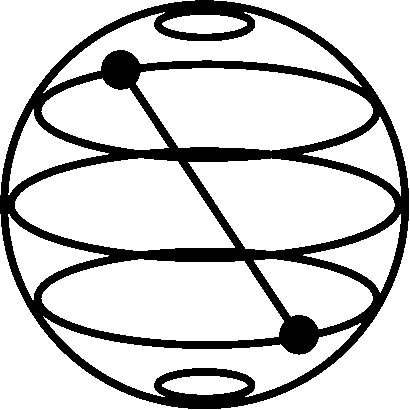

In [5]:
image_qiskit = qi.convert_to_bw("logo.jpg")
qi.image_from_array(image_qiskit)

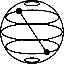

In [6]:
resized_image_qiskit = qi.resize_array(image_qiskit, size=(64, 64))
qi.image_from_array(resized_image_qiskit)

In [7]:
array_binary_qiskit = qi.binary_encode(resized_image_qiskit)
qi.save_bin_array_to_csv('qiskit_logo.csv', array_binary_qiskit)

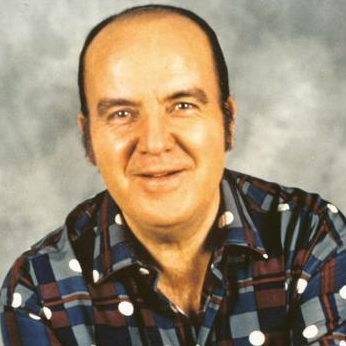

In [8]:
Image('quantum-fistro.png')

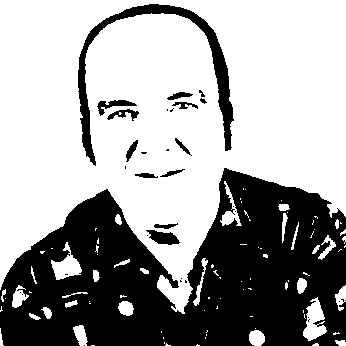

In [9]:
image_fistro = qi.convert_to_bw("quantum-fistro.png")
qi.image_from_array(image_fistro)

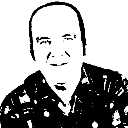

In [10]:
resized_image_fistro = qi.resize_array(image_fistro, size=(128, 128))
qi.image_from_array(resized_image_fistro)

In [11]:
array_binary_fistro = qi.binary_encode(resized_image_fistro)
qi.save_bin_array_to_csv('quantum_fistro.csv', array_binary_fistro)

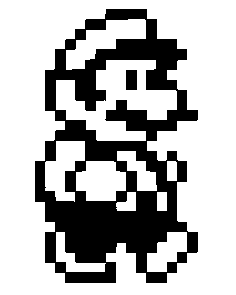

In [12]:
image = qi.convert_to_bw("mario.jpg")
qi.image_from_array(image)

In [13]:
image.shape

(295, 236)

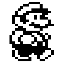

In [14]:
resized_image = qi.resize_array(image, size=(64, 64))
qi.image_from_array(resized_image)

In [15]:
array_binary = qi.binary_encode(resized_image)
qi.save_bin_array_to_csv('mario.csv', array_binary)

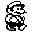

In [48]:
resized_image = qi.resize_array(image, size=(32, 32))
qi.image_from_array(resized_image)

In [49]:
array_binary = qi.binary_encode(resized_image)
qi.save_bin_array_to_csv('mario_tiny.csv', array_binary)

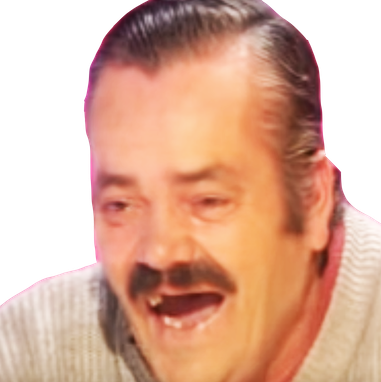

In [18]:
Image('quantum-risitas.png')

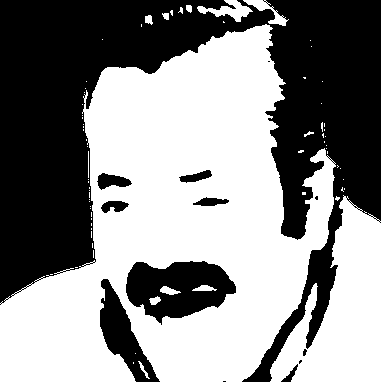

In [19]:
image_risitas = qi.convert_to_bw("quantum-risitas.png")
qi.image_from_array(image_risitas)

In [20]:
image_risitas.shape

(382, 381)

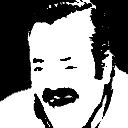

In [21]:
resized_image_risitas = qi.resize_array(image_risitas, size=(128, 128))
qi.image_from_array(resized_image_risitas)

In [22]:
array_binary_risitas = qi.binary_encode(resized_image_risitas)
qi.save_bin_array_to_csv('quantum_risitas.csv', array_binary_risitas)

# Use one-hot encoding drawing file to create a Quantum circuit and rebuild the image with the circuit result

# Only support square images (i.e: 32x32px, 64x64px)

In [23]:
def create_base_circuit(n_qubits):

    cr = ClassicalRegister(n_qubits, "c0")
    qr = QuantumRegister(n_qubits, "q0")

    base_circuit = QuantumCircuit(qr, cr)

    base_circuit.initialize(Statevector.from_label('1'*n_qubits).data, range(n_qubits));

    #[base_circuit.initialize([0, 1], i) for i in range(n_qubits)];
    
    return base_circuit

def splitting_chunks(n_cols):

    chunk_split = n_qubits

    num_splitting = int(n_cols / chunk_split) + (1 if int(n_cols % chunk_split) > 0 else 0)
    
    return num_splitting

def create_circuits(n_circuits, num_qubits):
    
    circuits = []

    for i in range(n_circuits):
        circuits.append(create_base_circuit(num_qubits))
        
    return circuits

def split_str(s):
    
    array = [ch for ch in s]
    
    return array

def rework_result_count(counts):

    result_value = [key for key, val in sorted(counts.items(), key = lambda ele: ele[1], reverse = True)]

    reverse_val = result_value[0][::-1]
    
    return reverse_val
    
def apply_gate(circuit, row):
    
    zeros = np.where(row == 0)
    zeros = zeros[0]

    circuit.barrier()
    
    if np.size(zeros) > 0:
        circuit.x(zeros.tolist())
    else:
        circuit.id(list(range(n_qubits)))
        
    circuit.measure(range(n_qubits), range(n_qubits))
    
    return circuit

def rebuild_image_quantum(binary_data, cols_items, splitting, n_qubits, backend, num_shots=1):
    
    final_array = []

    for item in binary_data:

        row_value = ''

        step = 0

        circ_copy = create_circuits(splitting, n_qubits)

        for circuit in circ_copy: 

            temp_step = step + n_qubits
            long_step = temp_step

            if long_step >= cols_items:

                long_step = cols_items

            chunk = item[step:long_step]

            apply_circuit = apply_gate(circuit, chunk)

            sim_counts = execute(circuit, backend=backend, shots=num_shots).result().get_counts()

            row_value = row_value + rework_result_count(sim_counts)

            if temp_step >= cols_items:

                diff = temp_step - cols_items

                row_value = row_value[:-diff]

            else:

                step = step + n_qubits

        array_row = split_str(row_value)

        final_array.append(array_row)

    rework_data = np.array(final_array, dtype='uint8')
    
    return rework_data

In [24]:
# Simulator
qasm_sim = Aer.get_backend("aer_simulator")

# Number of circuit qubits
n_qubits = 5

In [25]:
binary_data_array = qi.load_bin_array_from_csv('quantum_fistro.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(128, 128)

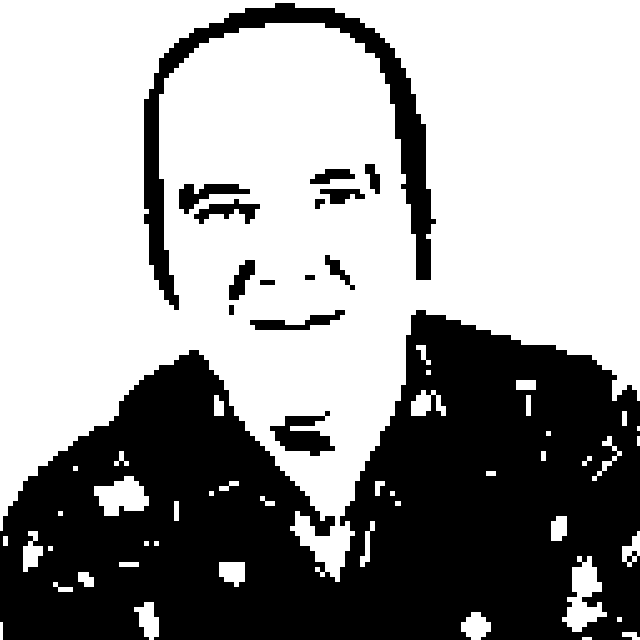

In [26]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

In [27]:
binary_data_array = qi.load_bin_array_from_csv('qiskit_logo.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(64, 64)

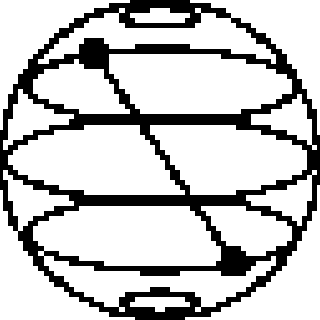

In [28]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

In [29]:
binary_data_array = qi.load_bin_array_from_csv('mario.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(64, 64)

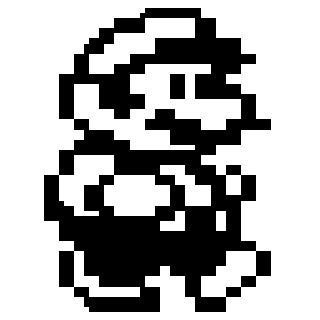

In [30]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

In [31]:
binary_data_array = qi.load_bin_array_from_csv('doge.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(64, 64)

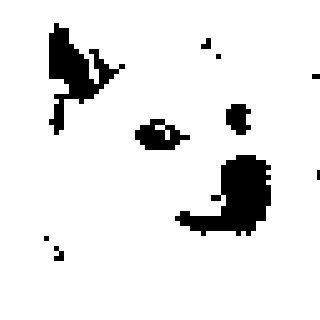

In [32]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

In [33]:
binary_data_array = qi.load_bin_array_from_csv('quantum_risitas.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(128, 128)

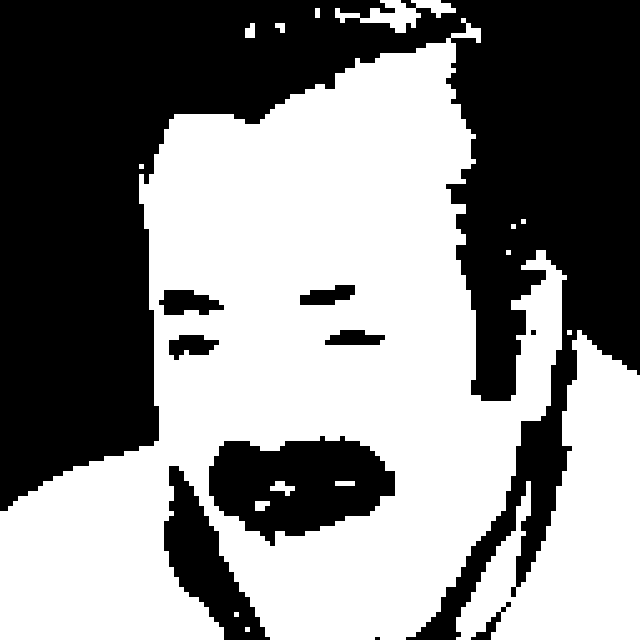

In [34]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

# Sending circuit to real quantum computer

In [37]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

In [38]:
if not IBMQ.active_account():
    IBMQ.load_account()

all_providers = IBMQ.providers()

provider = all_providers[0] #IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [39]:
import qiskit.tools.jupyter
%qiskit_backend_overview

In [40]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= n_qubits and b.status().operational and not b.configuration().simulator))

In [41]:
backend

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [50]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [51]:
binary_data_array = qi.load_bin_array_from_csv('mario_tiny.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, backend, num_shots = 1024)
rework_image.shape

(32, 32)

In [52]:
%qiskit_disable_job_watcher

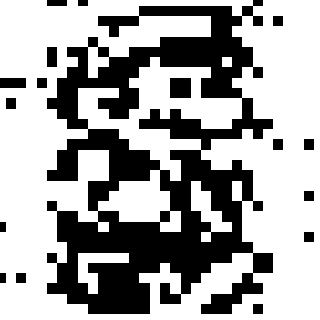

In [53]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 10)
qi.image_from_array(scaled_image)

In [46]:
%qiskit_version_table